In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install findspark

Note: you may need to restart the kernel to use updated packages.


In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import (VectorAssembler, OneHotEncoder, StringIndexer)
from pyspark.ml import Pipeline
from pyspark.ml.classification import (LogisticRegression, RandomForestClassifier, NaiveBayes)
from pyspark.sql.functions import (col, explode, array, lit)
from pyspark.ml.evaluation import (BinaryClassificationEvaluator, MulticlassClassificationEvaluator)
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName('HeartDiseaseClassification').getOrCreate()

Reading Data

In [5]:
df = spark.read.csv("D:/Final_Big_Data/heart_2020_cleaned.csv", header=True, inferSchema=True)

In [ ]:
df.show(5)

+------------+-----+-------+---------------+------+--------------+------------+-----------+------+-----------+-----+--------+----------------+---------+---------+------+-------------+----------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|PhysicalHealth|MentalHealth|DiffWalking|   Sex|AgeCategory| Race|Diabetic|PhysicalActivity|GenHealth|SleepTime|Asthma|KidneyDisease|SkinCancer|
+------------+-----+-------+---------------+------+--------------+------------+-----------+------+-----------+-----+--------+----------------+---------+---------+------+-------------+----------+
|          No| 16.6|    Yes|             No|    No|           3.0|        30.0|         No|Female|      55-59|White|     Yes|             Yes|Very good|      5.0|   Yes|           No|       Yes|
|          No|20.34|     No|             No|   Yes|           0.0|         0.0|         No|Female|80 or older|White|      No|             Yes|Very good|      7.0|    No|           No|        No|
|          No|26.58|    Y

In [ ]:
df.printSchema()

root
 |-- HeartDisease: string (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoking: string (nullable = true)
 |-- AlcoholDrinking: string (nullable = true)
 |-- Stroke: string (nullable = true)
 |-- PhysicalHealth: double (nullable = true)
 |-- MentalHealth: double (nullable = true)
 |-- DiffWalking: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- AgeCategory: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Diabetic: string (nullable = true)
 |-- PhysicalActivity: string (nullable = true)
 |-- GenHealth: string (nullable = true)
 |-- SleepTime: double (nullable = true)
 |-- Asthma: string (nullable = true)
 |-- KidneyDisease: string (nullable = true)
 |-- SkinCancer: string (nullable = true)



In [ ]:
label = 'HeartDisease'
numerical_cols = ['BMI', 'PhysicalHealth','MentalHealth','SleepTime']
categorical_cols = list(set(df.columns) - set(numerical_cols) -set([label]))

**Data Distribution**

In [ ]:
df.select(numerical_cols).describe().show()

+-------+------------------+------------------+-----------------+------------------+
|summary|               BMI|    PhysicalHealth|     MentalHealth|         SleepTime|
+-------+------------------+------------------+-----------------+------------------+
|  count|            319795|            319795|           319795|            319795|
|   mean|28.325398520925706|3.3717100017198516|3.898366140808956| 7.097074688472302|
| stddev| 6.356100200470763| 7.950850182571355|7.955235218943604|1.4360070609642803|
|    min|             12.02|               0.0|              0.0|               1.0|
|    max|             94.85|              30.0|             30.0|              24.0|
+-------+------------------+------------------+-----------------+------------------+



<Axes: title={'center': 'Number of Observations per label'}, xlabel='HeartDisease'>

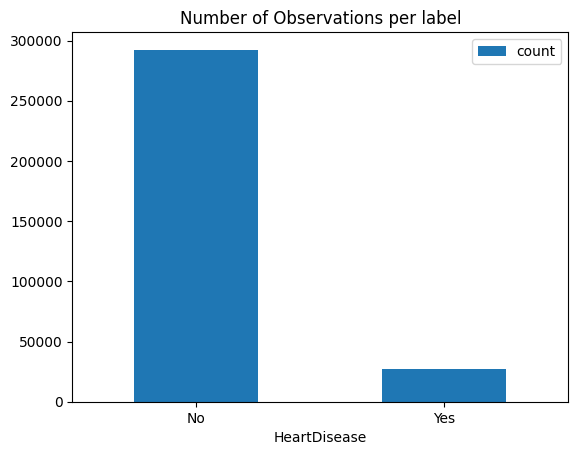

In [ ]:
df.groupBy(label).count().toPandas().plot.bar(x='HeartDisease', rot=0, title='Number of Observations per label')

**Preparing Data for Classification Models**


In [ ]:
train_df, test_df = df.randomSplit([.7,.3])

<Axes: title={'center': 'Number of Observations in Train subset after Oversampling'}, xlabel='HeartDisease'>

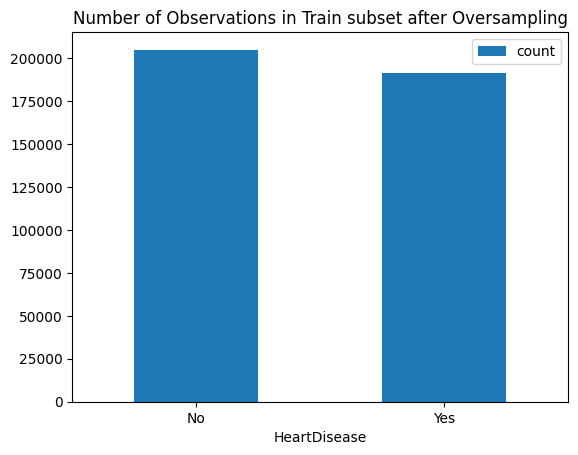

In [ ]:
major_df = train_df.filter(col(label) == 'No')
minor_df = train_df.filter(col(label) == 'Yes')

r = int(major_df.count()/minor_df.count())

oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in range(r)]))).drop('dummy')

combined_train_df = major_df.unionAll(oversampled_df)

combined_train_df.groupBy(label).count().toPandas().plot.bar(x='HeartDisease', rot=0, title='Number of Observations in Train subset after Oversampling')

In [ ]:
indexers = [StringIndexer(inputCol=col, outputCol=col+'_indexed') for col in categorical_cols]

encoders = [OneHotEncoder(inputCol=col+'_indexed', outputCol=col+'_encoded') for col in categorical_cols]

label_indexer = StringIndexer(inputCol=label, outputCol=label+'_indexed')

In [ ]:
assembler = VectorAssembler(inputCols= [col+'_encoded' for col in categorical_cols] + numerical_cols, outputCol='features')

In [ ]:
pipeline = Pipeline(stages= indexers + encoders + [label_indexer, assembler])

**Applying Classification Models**

**Models Implemented:**

**lr** - Logistic Regression

**rfc** - Random Forest Classifier

**nb** - Naive Bayes

In [ ]:
lr = LogisticRegression(featuresCol='features', labelCol=label+'_indexed')
rfc = RandomForestClassifier(featuresCol='features', labelCol=label+'_indexed', numTrees=100)
nb = NaiveBayes(featuresCol='features', labelCol=label+'_indexed')

In [ ]:
pipeline_lr = Pipeline(stages=[pipeline, lr])
pipeline_rfc = Pipeline(stages=[pipeline, rfc])
pipeline_nb = Pipeline(stages=[pipeline, nb])

In [ ]:
lr_fit = pipeline_lr.fit(combined_train_df)
rfc_fit = pipeline_rfc.fit(combined_train_df)
nb_fit = pipeline_nb.fit(combined_train_df)

In [ ]:
pred_lr = lr_fit.transform(test_df)
pred_rfc = rfc_fit.transform(test_df)
pred_nb = nb_fit.transform(test_df)

**Evaluating Results**

**Area Under Curve - AUC**

In [ ]:
pred_AUC = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol=label+'_indexed')

In [ ]:
AUC_lr = pred_AUC.evaluate(pred_lr)
AUC_rfc = pred_AUC.evaluate(pred_rfc)
AUC_nb = pred_AUC.evaluate(pred_nb)
print(AUC_lr, AUC_rfc, AUC_nb)


0.7629465261327041 0.7177769185880624 0.6176533808273955


**Accuracy - A poor Evaluation Metric for Unbalanced Classification**


In [ ]:
acc_all_negative = test_df.filter(test_df[label]=='No').count() / test_df.count()
acc_all_negative

0.9139981415162304

In [ ]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol=label+'_indexed', predictionCol="prediction", metricName="accuracy")

In [ ]:
acc_lr = acc_evaluator.evaluate(pred_lr)
acc_rfc = acc_evaluator.evaluate(pred_rfc)
acc_nb = acc_evaluator.evaluate(pred_nb)

print('Logistic Regression accuracy: ', '{:.2f}'.format(acc_lr*100), '%', sep='')
print('Random Forest accuracy: ', '{:.2f}'.format(acc_rfc*100), '%', sep='')
print('Naive Bayes accuracy: ', '{:.2f}'.format(acc_nb*100), '%', sep='')

Logistic Regression accuracy: 76.34%
Random Forest accuracy: 75.82%
Naive Bayes accuracy: 81.66%


**Confusion Matrices**

In [ ]:
def confusion_matrix(pred_df):
    preds_labels = pred_df.select(['prediction', label+'_indexed']).withColumn(label+'_indexed', F.col(label+'_indexed').cast(FloatType())).orderBy('prediction')
    metrics = MulticlassMetrics(preds_labels.rdd.map(tuple))
    return metrics.confusionMatrix().toArray()

In [ ]:
def confusion_matrix_plot(conf_mat, ax, title = 'Confusion Matrix'):
    names = ['True Negative','False Positive','False Negative','True Positive']

    number = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]

    percent = ["{0:.2%}".format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]

    labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1, v2, v3 in zip(names, number, percent)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues', cbar=False, ax=ax)

    ax.set_title(title+'\n');
    ax.set_xlabel('\nPredicted Labels')
    ax.set_ylabel('Real Labels');

    ax.xaxis.set_ticklabels(['No','Yes'])
    ax.yaxis.set_ticklabels(['No','Yes'])

    return ax

In [ ]:
conf_lr = confusion_matrix(pred_lr)
conf_rfc = confusion_matrix(pred_rfc)
conf_nb = confusion_matrix(pred_nb)


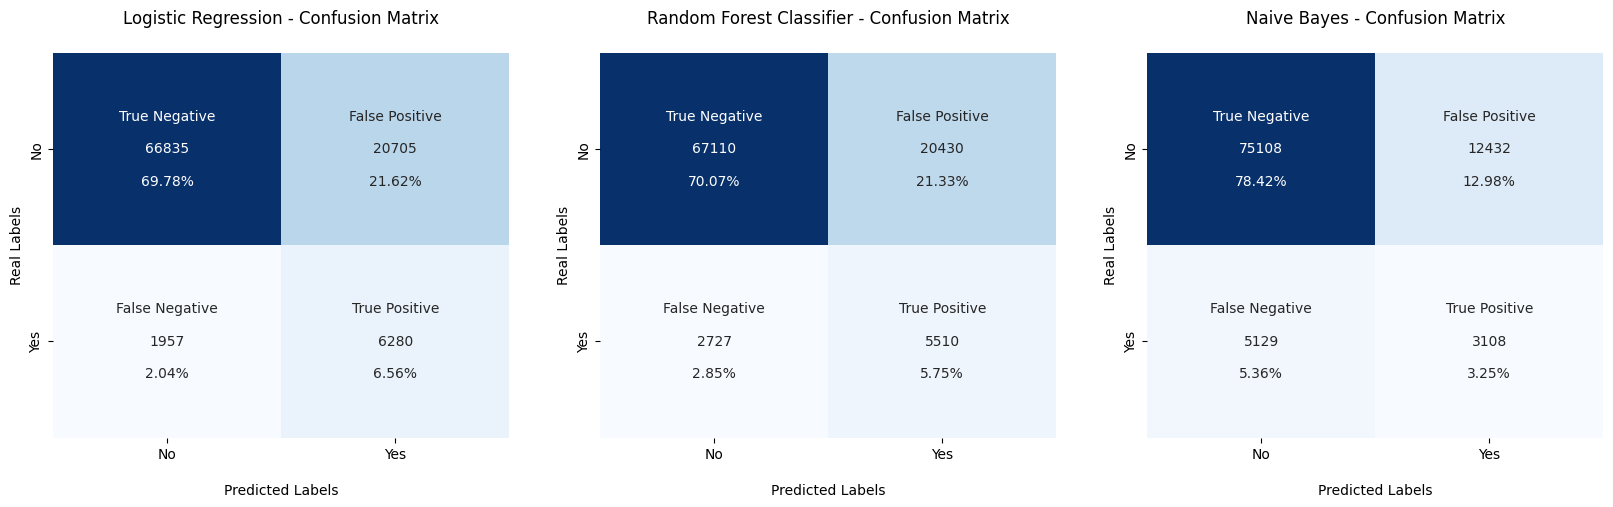

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

ax1 = confusion_matrix_plot(conf_lr, ax1,'Logistic Regression - Confusion Matrix')
ax2 = confusion_matrix_plot(conf_rfc, ax2,'Random Forest Classifier - Confusion Matrix')
ax3 = confusion_matrix_plot(conf_nb, ax3, 'Naive Bayes - Confusion Matrix')

plt.show()